### 3.6 WP5: Poroelasticity

#### 3.6.1 Exercise 1: Biot coefficient determination

The file BiotCoeffExperiment.xlsx has data from a laboratory experiment on a reservoir sandstone that shows axial and radial deformations caused by alternating variations of confining stress $P_c$ and pore pressure $P_p$.

a. Plot pressure and stresses as a function of time. 

b. What are the dPc/dt and dPp/dt loading rates when either confining or pore pressure are increased?? 

---

The loading rates are approx. 5 psi/s.

---

c. Fit a straight line to the data to obtain a unique relationship between $\varepsilon_{vol}$ and $\sigma_{mean}$ (effective), and calculate the bulk Biot coefficient $\alpha$. Assuming isotropic elasticity and that the Poisson Ratio is 0.25, what is the Young's modulus? 

d. Plot together the volumetric strain with Terzaghi’s and Biot’s effective stresses. 

e. If permeability is k = 100 mD, the fluid is water, porosity is 0.28, and the sample length is 0.05 m with top and bottom drainage, what is the characteristic time for pore pressure diffusion $T_{ch}$? How does it compare to the pressure/stress loading time? Would it be drained or undrained loading? Note: you need the diffusivity parameter for which you have to look up for properties of water. 

f.  EXTRA: Use the theory of transverse isotropic poro-elasticity to figure out the stress paths needed to measure directly $\alpha_h$ and $\alpha_v$. 

<IPython.core.display.Latex object>

### Find Biot coefficient and Young Modulus ###
Biot = 0.90 minimizes gets to the most linear results (R^2 = 0.98).
K = slope = 462381.2 psi = 3.19 GPa.
E = Young Module = 462381.2 psi = 4.78 GPa.
### Find Relaxation time ###
Diffusivity: 0.660 m2/s
Tch: 0.95 ms
As Tch << T_load, the experiment is DRAINED.


''

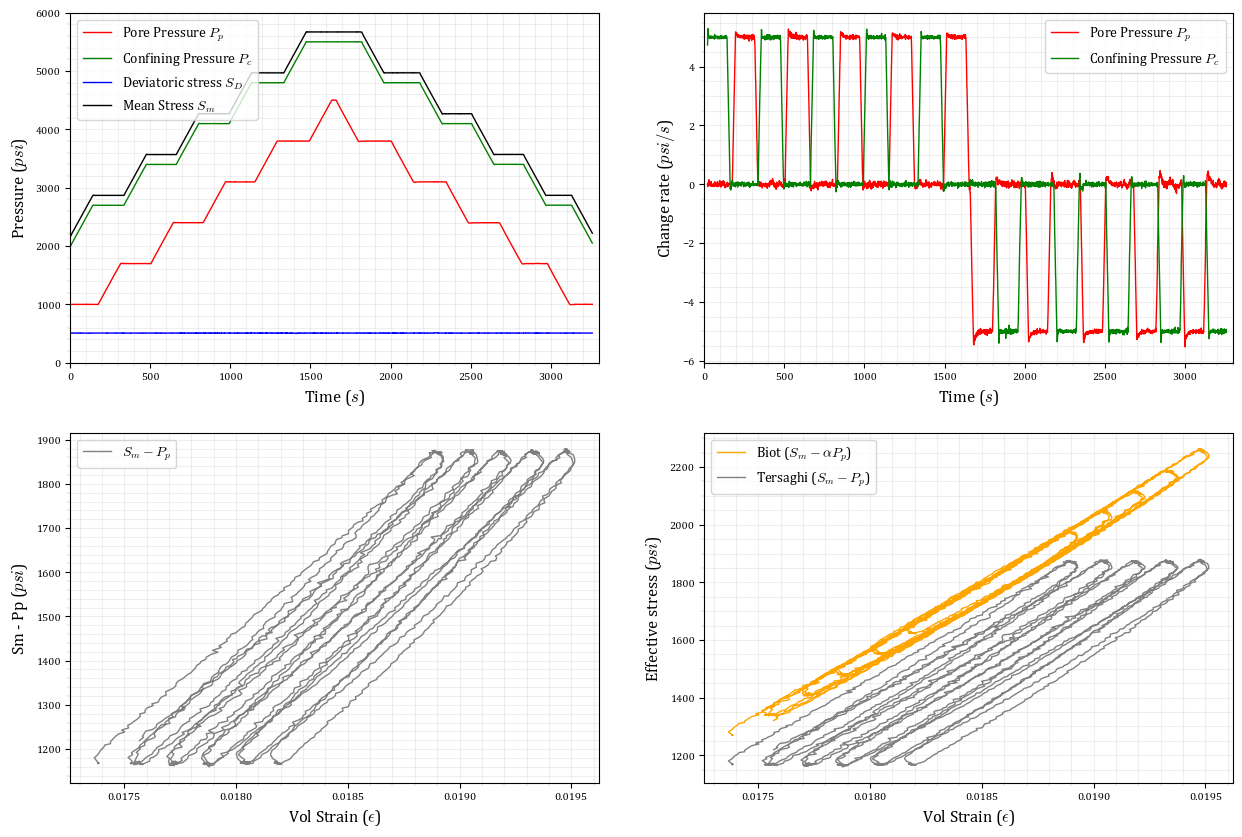

In [2]:
# Support functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

df = pd.read_excel("BiotExp_fmt.xlsx")

df["Pp_psi_s"] = ( df.Pp_psi - df.Pp_psi.shift() ) / ( df.time_s - df.time_s.shift() )
df["Pp_psi_s"] = df.Pp_psi_s.rolling(20).mean()
df["Pc_psi_s"] = ( df.Pc_psi - df.Pc_psi.shift() ) / ( df.time_s - df.time_s.shift() )
df["Pc_psi_s"] = df.Pc_psi_s.rolling(20).mean()

df["strain_vol"] = 2*df.strain_rad + df.strain_ax
df["Sm_psi"] = ( 3*df.Pc_psi + df.Sd_psi ) / 3
df["Sm-Pp"] = df.Sm_psi - df.Pp_psi


# Optimize Biot
from scipy.optimize import minimize
from scipy.stats import linregress
def linreg_biot(alpha) :
    slope, intercept, r_value, p_value, std_err = linregress( df.strain_vol, (df.Sm_psi-alpha* df.Pp_psi) )
    return (1 - r_value**2 )**2
res = minimize( linreg_biot, 0.5 )
alpha = res.x[0]

df["Sm-alpha_Pp"] = df.Sm_psi - alpha* df.Pp_psi
slope, intercept, r_value, p_value, std_err = linregress(df.strain_vol,df["Sm-alpha_Pp"])

from IPython.display import display, Math, Latex
display(Latex(r"\newpage"))

print("### Find Biot coefficient and Young Modulus ###")
print(f"Biot = {alpha:.2f} minimizes gets to the most linear results (R^2 = {r_value**2:.2f}).")

nu = 0.25
K_Pa = slope * 6894.76
E_Pa = K_Pa * 3 * ( 1 - 2 * nu )
print(f"K = slope = {slope:.1f} psi = {K_Pa/1e9:.2f} GPa.")
print(f"E = Young Module = {slope:.1f} psi = {E_Pa/1e9:.2f} GPa.")

k_D = 0.1 # Permeability
k_m2 = k_D * 9.869233e-13

phi = 0.28
L_m = 0.05/2
mu_Pa_s = 1e-3
Kf_Pa = 2.1e9 # Pa - water bulk modulus
Ks_Pa = 38e9 # Pa - quarttz bulk modulus

M_Pa = 1 / ( ( alpha - phi )/Ks_Pa + phi/Kf_Pa )

Diffusivity = k_m2 * M_Pa / mu_Pa_s
Tch_s = L_m**2 / Diffusivity

print("### Find Relaxation time ###")
print(f"Diffusivity: {Diffusivity:.3f} m2/s")
print(f"Tch: {Tch_s*1e3:.2f} ms")
print("As Tch << T_load, the experiment is DRAINED.")

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2)
fig.set_size_inches( 15, 10 )

ax=ax1
ax.plot( df.time_s, df.Pp_psi, c='red', label="Pore Pressure $P_p$" )
ax.plot( df.time_s, df.Pc_psi, c='green',label="Confining Pressure $P_c$" )
ax.plot( df.time_s, df.Sd_psi, c='blue', label="Deviatoric stress $S_D$" )
ax.plot( df.time_s, df.Sm_psi, c='black',label="Mean Stress $S_m$" )


ax.set_ylim( 0,6000 )
ax.set_xlim( 0,3300 )
ax.set_xlabel("Time ($s$)")
ax.set_ylabel("Pressure ($psi$)")
ax.legend()

ax=ax2
ax.plot( df.time_s, df.Pp_psi_s, c='red', label="Pore Pressure $P_p$" )
ax.plot( df.time_s, df.Pc_psi_s, c='green',label="Confining Pressure $P_c$" )

ax.set_xlim( 0,3300 )
ax.set_xlabel("Time ($s$)")
ax.set_ylabel("Change rate ($psi/s$)")
ax.legend()

ax=ax3
ax.plot( df.strain_vol, df["Sm-Pp"], c='gray',label="$S_m-P_p$" )
#ax.set_xlim( 0,3300 )
ax.set_xlabel("Vol Strain ($\epsilon$)")
ax.set_ylabel("Sm - Pp ($psi$)")
ax.legend()

ax=ax4
ax.plot( df.strain_vol, df["Sm-alpha_Pp"], c='orange',label=r"Biot ($S_m-\alpha P_p$)" )
ax.plot( df.strain_vol, df["Sm-Pp"], c='gray',label=r"Tersaghi ($S_m- P_p$)" )
#ax.set_xlim( 0,3300 )
ax.set_xlabel("Vol Strain ($\epsilon$)")
ax.set_ylabel(r"Effective stress ($psi$)")
ax.legend()

''
